In [1]:
%matplotlib widget

In [2]:
import logging
import pathlib
import sys
from typing import Any, Callable, Optional, Tuple, cast

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
from watchdog.events import FileSystemEvent, PatternMatchingEventHandler
from watchdog.observers.polling import PollingObserver as Observer

from ska_pst.stat import Statistics

In [3]:
observer: Optional[Observer] = None

In [4]:
# override format here for more or less logging information
# also update the logging level for different level of logging verbosity
logging.basicConfig(
    format="%(asctime)s | %(levelname)s : %(message)s",
    level=logging.INFO,
    stream=sys.stdout,
)

logger = logging.getLogger()

In [5]:
class MonitoringFileEventHandler(PatternMatchingEventHandler):
    r"""An event handler for when STAT monitoring files are created.

    Instances of this class can be used as a handler within a
    `watchdog.observer.Observer` instance. This specific
    class will only handle files that match the following pattern
    from the monitoring path of the observer.

    The file pattern matched is: `\*\*/monitoring_stats/\*.h5`
    """

    def __init__(
        self,
        callback: Callable[[pathlib.Path], None],
        logger: Optional[logging.Logger] = None,
    ) -> None:
        """Create instance of the event handler.

        :param callback: the callback to use when a new monitoring file is created.
        :type callback: Callable
        :param logger: the logger for logging, defaults to None
        :type logger: Optional[logging.Logger], optional
        """
        self._callback = callback
        self._logger = logger or logging.getLogger()
        super().__init__(patterns=["**/monitoring_stats/*.h5"], ignore_directories=True, case_sensitive=True)

    def on_created(self, event: FileSystemEvent) -> None:
        """Handle a file created event.

        This method will call the callback provided in the constructor
        with the path to the file.

        :param event: the file system event, this is specifically a file created event.
        :type event: FileSystemEvent
        """
        self._logger.info(f"Recevied event {event}")
        try:
            self._callback(pathlib.Path(event.src_path))
        except Exception:
            self._logger.exception("Exception occured while handling on created file", exc_info=True)

In [6]:
header_out = widgets.Output()
header_out = widgets.Output()

value_widgets_map = {
    data_type: {
        pol: {
            dim: {
                stat: widgets.Text(disabled=True, description=f"{dim} {stat}: ")
                for stat in ["Mean", "Var.", "Num. Clipped"]
            }
            for dim in ["Real", "Imag"]
        }
        for pol in ["A", "B"]
    }
    for data_type in ["all", "rfi_excised"]
}

scalar_stats_tab = widgets.Tab()
scalar_stats_tab.children = [
    widgets.HBox(
        [
            widgets.VBox([value_widgets_map[dt][pol][dim][stat] for stat in ["Mean", "Var.", "Num. Clipped"]])
            for dim in ["Real", "Imag"]
        ]
    )
    for dt in ["all", "rfi_excised"]
    for pol in ["A", "B"]
]
scalar_stats_tab.titles = ["Pol A", "Pol B", "Pol A (RFI Excised)", "Pol B (RFI Excised)"]

In [7]:
plt.ion()
with plt.ioff():
    fig = plt.figure(figsize=(8, 9))

# display plots
fig.suptitle("PST Voltage Recorder Statistics")
fig.canvas.toolbar_visible = False  # type: ignore
fig.canvas.header_visible = False  # type: ignore
fig.canvas.footer_visible = False  # type: ignore
fig.canvas.resizable = False  # type: ignore

gs = plt.GridSpec(5, 2, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(gs[0, :])
ax1.set_xlabel("Time Sample")
ax1.set_ylabel("Channel")

ax2 = plt.subplot(gs[1, :])
ax2.set_ylabel("Power")
ax2.set_xlabel("Time Sample")

ax3 = plt.subplot(gs[2, :])
ax3.set_xlabel("Channel")
ax3.set_ylabel("Power")

ax4 = plt.subplot(gs[3:, 0])
ax4.set_xlabel("Input state")
ax4.set_ylabel("Counts")

ax5 = plt.subplot(gs[3:, 1])
ax5.set_xlabel("Real")
ax5.set_ylabel("Imag")


def _set_scalar_stats_widgets_value(scalar_stats: pd.DataFrame, rfi_excised: bool) -> None:
    value_widgets = value_widgets_map["rfi_excised"] if rfi_excised else value_widgets_map["all"]
    for pol in ["A", "B"]:
        pol_widgets = value_widgets[pol]
        for dim in ["Real", "Imag"]:
            dim_widgets = pol_widgets[dim]
            for stat in ["Mean", "Var.", "Clipped"]:
                value: Any = scalar_stats.loc[pol, dim][stat]  # type: ignore
                if stat == "Clipped":
                    cast(widgets.Text, dim_widgets["Num. Clipped"]).value = str(int(value))
                else:
                    cast(widgets.Text, dim_widgets[stat]).value = str(np.round(value, 3))


def print_header(stats: Statistics, out: widgets.Output) -> None:
    # formatter should not be None in Jupyter but it is a linting issue.
    formatter = InteractiveShell.instance().display_formatter
    if formatter is None:
        return

    fmt = formatter.format

    data = {
        "": [
            "Execution Block ID",
            "Scan ID",
            "UTC Start Time",
            "Start Time Offset (secs)",
            "End End Offset (secs)",
            "Num. Statistic Samples",
            "Num. Statistic Samples (RFI Excised)",
            "Num. Invalid Packets",
        ],
        "Value": [
            stats.metadata.eb_id,
            stats.metadata.scan_id,
            stats.metadata.utc_start,
            stats.metadata.t_min,
            stats.metadata.t_max,
            stats.metadata.num_samples,
            stats.metadata.num_samples_rfi_excised,
            stats.metadata.num_invalid_packets,
        ],
    }
    df = pd.DataFrame(data=data)
    df.set_index("", inplace=True)
    data, metadata = fmt(df)
    out.outputs = tuple([{"output_type": "display_data", "data": data, "metadata": metadata}])


def handle_monitoring_file_updated(header_out: widgets.Output) -> Callable[[pathlib.Path], None]:
    def _handle(file: pathlib.Path) -> None:
        stats = Statistics.load_from_file(file)

        print_header(stats, header_out)

        _set_scalar_stats_widgets_value(stats.frequency_averaged_stats, rfi_excised=False)
        _set_scalar_stats_widgets_value(stats.frequency_averaged_stats_rfi_excised, rfi_excised=True)

        spectrogram_pol_a = stats.pol_a_spectrogram
        mean = np.mean(spectrogram_pol_a)
        stddev = np.std(spectrogram_pol_a)
        minval = float(mean - 3.0 * stddev)
        maxval = float(mean + 3.0 * stddev)

        # Timeseries Plot
        pol_a_timeseries = stats.pol_a_timeseries
        pol_b_timeseries = stats.pol_b_timeseries

        # Spectral Power Plot
        pol_a_spectral_power = stats.pol_a_spectral_power
        pol_b_spectral_power = stats.pol_b_spectral_power

        # Histogram
        pol_a_real_histogram = stats.pol_a_real_histogram
        stats.pol_a_imag_histogram

        # find last zero count before any counts
        def find_count_bounds(df: pd.DataFrame, column: str = "Count") -> Tuple[int, int]:
            nonzeros = df[df[column] != 0].index
            return (nonzeros[0], nonzeros[-1])  # type: ignore

        nbin = stats.metadata.histogram_nbin
        pol_a_real_histogram = stats.pol_a_real_histogram
        pol_b_real_histogram = stats.pol_b_real_histogram

        (pol_a_low_idx, pol_a_high_idx) = find_count_bounds(stats.pol_a_real_histogram)
        (pol_b_low_idx, pol_b_high_idx) = find_count_bounds(stats.pol_b_real_histogram)

        low_idx = max(0, min(pol_a_low_idx, pol_b_low_idx) - 1)
        high_idx = min(nbin - 1, max(pol_a_high_idx, pol_b_high_idx) + 1)
        centre_idx = nbin // 2
        diff = max(np.abs(centre_idx - low_idx), np.abs(high_idx - centre_idx))
        low_idx = max(0, centre_idx - diff)
        high_idx = min(nbin - 1, centre_idx + diff)

        xbins = np.arange(low_idx, high_idx + 1)
        pol_a_real_histogram = pol_a_real_histogram.iloc[xbins]["Count"]  # type: ignore
        pol_b_real_histogram = pol_b_real_histogram.iloc[xbins]["Count"]  # type: ignore

        xbins = xbins - centre_idx

        pol_a_2d_data = stats.pol_a_rebinned_histogram2d
        nrebin = stats.metadata.nrebin
        n = nrebin // 2
        histogram_bounds = np.arange(-n, n)

        ax1.cla()
        ax1.imshow(spectrogram_pol_a, origin="lower", vmin=minval, vmax=maxval, aspect="auto")
        ax1.set_xlabel("Time Sample")
        ax1.set_ylabel("Channel")

        ax2.cla()
        ax2.plot(pol_a_timeseries["Mean"], label="polA")
        ax2.plot(pol_b_timeseries["Mean"], label="polB")
        ax2.set_xlim(0, len(pol_a_timeseries["Mean"]))
        ax2.set_ylabel("Power")
        ax2.set_xlabel("Time Sample")

        ax3.cla()
        ax3.plot(pol_a_spectral_power["Mean"], label="polA")
        ax3.plot(pol_b_spectral_power["Mean"], label="polB")
        ax3.set_xlim(0, len(pol_a_spectral_power["Mean"]))
        ax3.set_xlabel("Channel")
        ax3.set_ylabel("Power")

        ax4.cla()
        ax4.set_xlim((xbins[0], xbins[-1]))
        ax4.plot(xbins, pol_a_real_histogram, label="polA")
        ax4.set_xlabel("Input state")
        ax4.set_ylabel("Counts")
        ax4.legend()

        # 2D Histogram
        ax5.cla()
        ax5.contour(histogram_bounds, histogram_bounds, pol_a_2d_data)
        ax5.set_xlabel("Real")
        ax5.set_ylabel("Imag")

        fig.canvas.draw_idle()
        fig.canvas.flush_events()

    return _handle

In [8]:
event_handler = MonitoringFileEventHandler(
    callback=handle_monitoring_file_updated(header_out),
    logger=logger,
)

In [9]:
if observer is not None and observer.is_alive():
    observer.stop()
    observer.join()

scan_path = pathlib.Path("/mnt/lfs/product")
observer = Observer()
observer.schedule(event_handler=event_handler, path=scan_path, recursive=True)
observer.start()

Output()

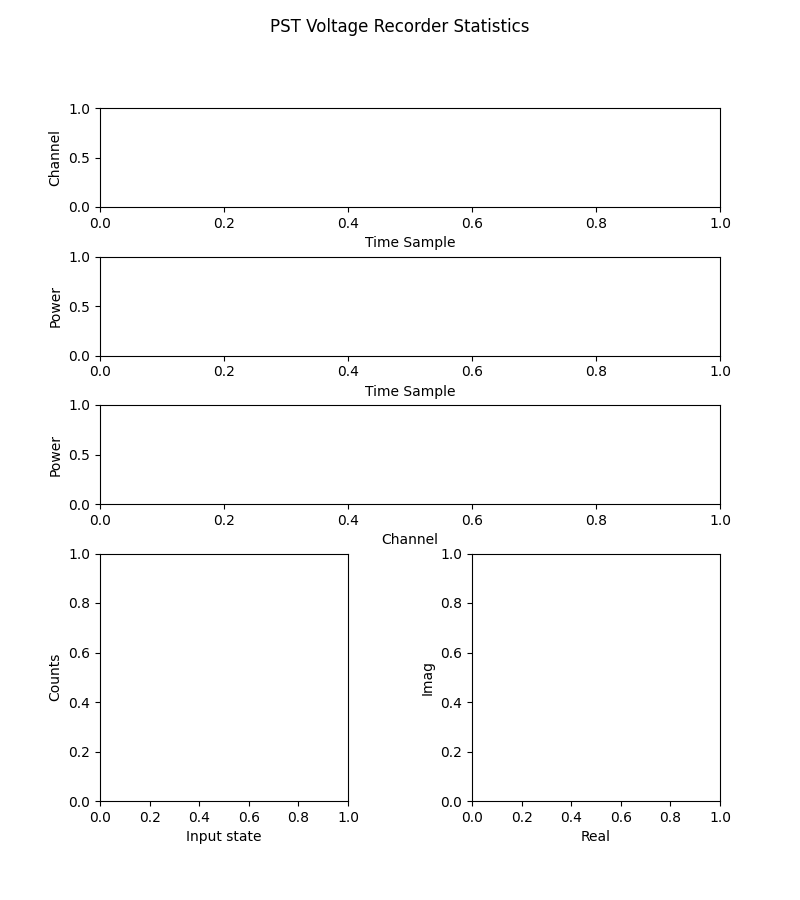

2023-11-21 00:18:19,584 | INFO : Recevied event <FileCreatedEvent: event_type=created, src_path='/mnt/lfs/product/eb-h064-20231121-76088/pst-low/327/monitoring_stats/2023-11-21-00:18:15_0000000083165184_000001.h5', is_directory=False>


In [10]:
display(header_out)
display(scalar_stats_tab)
display(fig.canvas)

In [11]:
observer.stop()
observer.join()